### Import Necessary Module and Set Path 

In [1]:
import sqlite3 as lite
import os
import sys
import numpy as np
import collections
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()
from IPython.display import Image
import matplotlib.pyplot as plt
import os

In [2]:
import analysis as an

In [3]:
# get sqlite cursor and simulation time data
cur = an.get_cursor('./2035_0_005_growth/output.sqlite')
init_year, init_month, duration, timestep = an.get_timesteps(cur)

In [4]:
# get number of reactors and capacity timeseries
an.plot_power(cur)

blanket_inst has no values
Sink_Source_Inst has no values
Sink_Source_Inst has no values


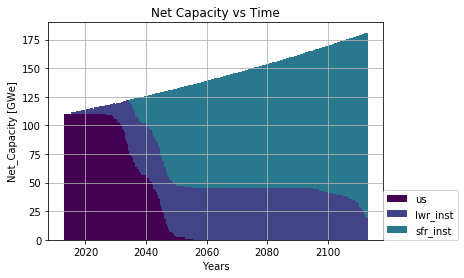

In [5]:
Image('power_plot.png')

In [6]:
# get isotopics for input and output recipe
def get_element_content(cur, commodity, z):
    
    query = cur.execute('SELECT * FROM transactions '
                        'INNER JOIN resources ON '
                        'resources.resourceid = transactions.resourceid '
                        'WHERE commodity = "%s"' %commodity).fetchall()
    for i in query:
        qualid = i['qualid']
        break
    query = cur.execute('SELECT NucId, MassFrac FROM compositions '
                        'WHERE qualid = %i' %qualid).fetchall()
    el_content = 0
    for row in query:
        if row['NucId'] // 1e7 == z:
            el_content += row['MassFrac']
    return el_content


In [7]:
# pu avail timeseries
    
def get_element_inv(cur, z):
    # gets the pu timeseries
    lwr_frac = get_element_content(cur, 'uox_waste', z)
    sfr_frac = get_element_content(cur, 'sfr_used', z)
    blanket_frac = get_element_content(cur, 'blanket_used', z)
    legacy_frac = get_element_content(cur, 'pre_2013_unf', z)
    
    storage_id = an.get_agent_ids(cur, 'Storage')
    cool = an.facility_commodity_flux(cur, storage_id,
                                      ['cooled_uox', 'cooled_sfr', 'cooled_blanket'],
                                      True, True)
    source_id = an.get_agent_ids(cur, 'Source')
    legacy = an.facility_commodity_flux(cur, source_id, ['pre_2013_unf'], True, True)

    uox_el = np.array(cool['cooled_uox']) * lwr_frac
    sfr_el = np.array(cool['cooled_sfr']) * sfr_frac
    blanket_el = np.array(cool['cooled_blanket']) * blanket_frac
    print('BLANKET FRAC: %f' %blanket_frac)
    print('DRIVER FRAC: %f' %sfr_frac)
    
    legacy_el = np.array(legacy['pre_2013_unf']) * legacy_frac
    el_dict = {'uox': uox_el, 'sfr': sfr_el, 'legacy': legacy_el, 'blanket': blanket_el}
    return el_dict




In [10]:
# pu usage
def get_element_usage(cur, z):
    sfr_in_el_frac = get_element_content(cur, 'sfr_fuel_legacy', z)
    print('PU IN DRIVER FUEL: %f' %sfr_in_el_frac)
    # fuel input
    mixer =an.get_agent_ids(cur, 'mixer')
    fuel_usage = an.facility_commodity_flux(cur, mixer,
                                        ['sfr_fuel_legacy', 'sfr_fuel_new'],
                                        True, True)
    el_use_dict = {'from_uox': np.array(fuel_usage['sfr_fuel_legacy']) * sfr_in_el_frac,
                   'from_sfr': np.array(fuel_usage['sfr_fuel_new']) * sfr_in_el_frac}
    return el_use_dict


BLANKET FRAC: 0.053485
DRIVER FRAC: 0.146244
PU IN DRIVER FUEL: 0.149918


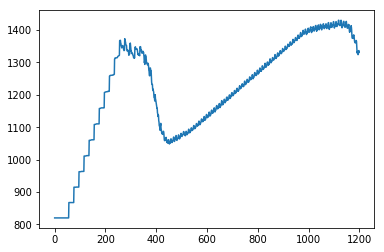

In [11]:
plt.close()

# pu accumulation and usage timeseries
pu_dict = get_element_inv(cur, 94)
pu_usage = get_element_usage(cur, 94)

net = sum(pu_dict.values()) -sum(pu_usage.values())
plt.plot(net)
plt.show()
plt.close()


STARTUP PU: 2766.886608
EOL DISCHARGE PU: 2454.615120
1692.8534960000106
1.0363461060988381


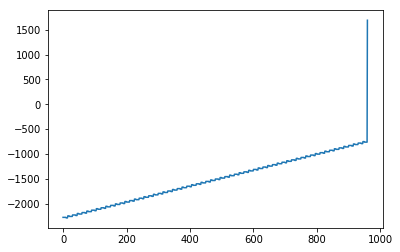

In [29]:
# calculating breeding ratio:
# sfr lifetime pu anlaysis

driver_batch_size = 3076
driver_n_batch = 5
driver_cycle_time = 9
driver_refuel_time = 1

blanket_batch_size = 768
blanket_cycle_time = 14
blanket_n_batch = 5
blanket_refuel_time = 1

pu_usage = np.zeros(960)
pu_usage[0] = driver_n_batch * driver_batch_size * 0.149918
pu_gain = np.zeros(960)

for i in range(960):
    if i % (driver_cycle_time + driver_refuel_time) == 0:
        pu_usage[i] += driver_batch_size * 0.149918
        pu_gain[i] += driver_batch_size * 0.146244
    if i % (blanket_cycle_time + blanket_refuel_time) == 0:
        pu_gain[i] += blanket_batch_size * 0.053485

# EOL discharge
pu_gain[-1] += driver_n_batch * driver_batch_size * 0.146244
pu_gain[-1] += blanket_n_batch * blanket_batch_size * 0.053485 
# cumulative gain
total_gain = np.cumsum(pu_gain)[-1] - np.cumsum(pu_usage)[-1]
ratio = np.cumsum(pu_gain)[-1] / np.cumsum(pu_usage)[-1]
print('STARTUP PU: %f' %pu_usage[0])
print('EOL DISCHARGE PU: %f' %pu_gain[-1])
print(total_gain)
print(ratio)

plt.plot(np.cumsum(pu_gain) - np.cumsum(pu_usage))


In [26]:
print(len(sum(pu_usage.values())))

1200


In [27]:
print(pu_dict)

{'uox': array([   0.        ,    0.        ,    0.        , ..., 1708.07739068,
       1709.56815917, 1710.31354341]), 'sfr': array([   0.        ,    0.        ,    0.        , ..., 9633.04192165,
       9653.28507503, 9673.07838056]), 'legacy': array([819.92842128, 819.92842128, 819.92842128, ..., 819.92842128,
       819.92842128, 819.92842128]), 'blanket': array([  0.        ,   0.        ,   0.        , ..., 608.13976706,
       609.37206649, 610.27575274])}


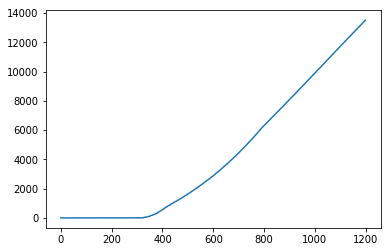

In [146]:
plt.plot(sum(pu_usage.values()))

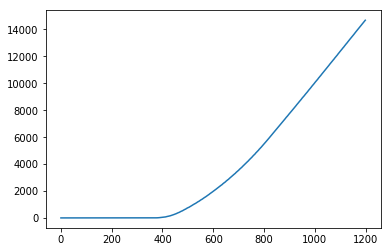

In [142]:
plt.plot(pu_dict['sfr'])

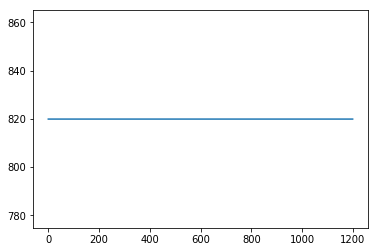

In [143]:
plt.plot(pu_dict['legacy'])

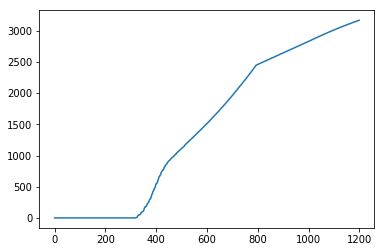

In [144]:
plt.plot(pu_usage['from_uox'])

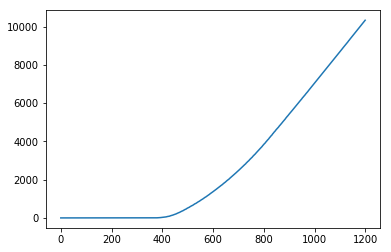

In [145]:
plt.plot(pu_usage['from_sfr'])

In [ ]:
uox = an.get_agent_ids(cur, 'reactor')
influx = an.facility_commodity_flux(cur, uox,
                                         ['uox_waste'],
                                         True, False)
plt.plot(influx['uox_waste'])


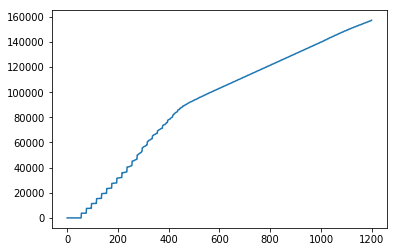

In [65]:

uox_rep = an.get_prototype_id(cur, 'reprocessing')
influx = an.facility_commodity_flux(cur, uox_rep,
                                         ['cooled_uox', 'pre_2013_unf'],
                                         False, True)
total = [x+y for x,y in zip(influx['cooled_uox'], influx['pre_2013_unf'])]
total = influx['cooled_uox']
plt.plot(total)

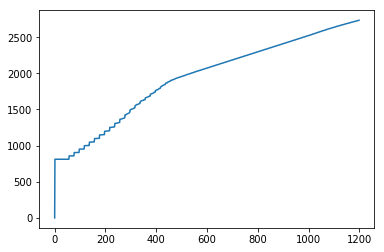

In [66]:
uox_rep = an.get_prototype_id(cur, 'reprocessing')
outflux = an.facility_commodity_flux(cur, uox_rep,
                                         ['lwr_pu'],
                                         True, True)
plt.plot(outflux['lwr_pu'])


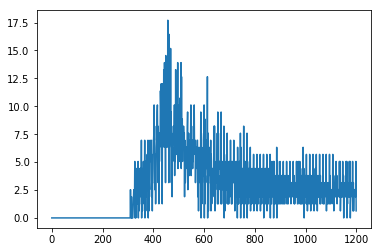

In [29]:
uox_rep = an.get_prototype_id(cur, 'sfr_reprocessing')
outflux = an.facility_commodity_flux(cur, uox_rep,
                                         ['sfr_pu'],
                                         True, False)
plt.plot(outflux['sfr_pu'])


157199.437


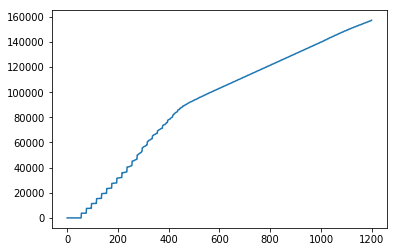

In [76]:
uox_unf = an.get_agent_ids(cur, 'storage')
uox = an.facility_commodity_flux(cur, uox_unf, ['cooled_uox'], True, True)
plt.plot(uox['cooled_uox'])
print(uox['cooled_uox'][-1])

[     0.        0.        0.   ... 405799.68 405936.96 406211.52]


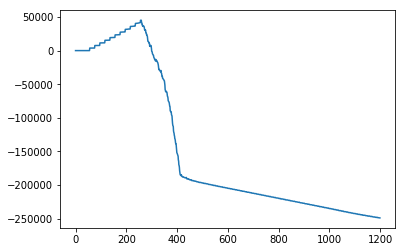

In [77]:
lwr_mixer = an.get_prototype_id(cur, 'sfr_mixer_lwr')
outflux = an.facility_commodity_flux(cur, lwr_mixer,
                                     ['sfr_fuel_legacy'],
                                     True, True)
outflux = np.array(outflux['sfr_fuel_legacy'])
unf_for_sfr_fuel = 1 * 0.0869 / (0.01)
influx = an.facility_commodity_flux(cur, lwr_mixer, ['lwr_pu'], False, True)
unf_needed = outflux * unf_for_sfr_fuel
print(unf_needed)
plt.plot(np.array(uox['cooled_uox']) - unf_needed)

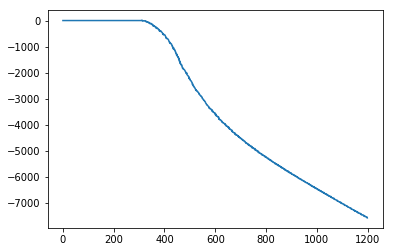

In [30]:
sfr_mixer = an.get_prototype_id(cur, 'sfr_mixer_sfr')
outflux = an.facility_commodity_flux(cur, sfr_mixer,
                                     ['sfr_fuel_new'],
                                     True, True)
outflux = np.array(outflux['sfr_fuel_new'])
influx = an.facility_commodity_flux(cur, sfr_mixer, ['sfr_pu'], False, True)
influx = np.array(influx['sfr_pu']) / 0.22
plt.plot(influx - outflux)